In [1]:
pip install pandas numpy yfinance scikit-learn matplotlib seaborn streamlit

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 27.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 90.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 90.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 90.8 MB/s eta 0:00:00
  DEPRECATION: Building 'multitasking' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'multitasking'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  Created wheel for multitasking: filename=mul

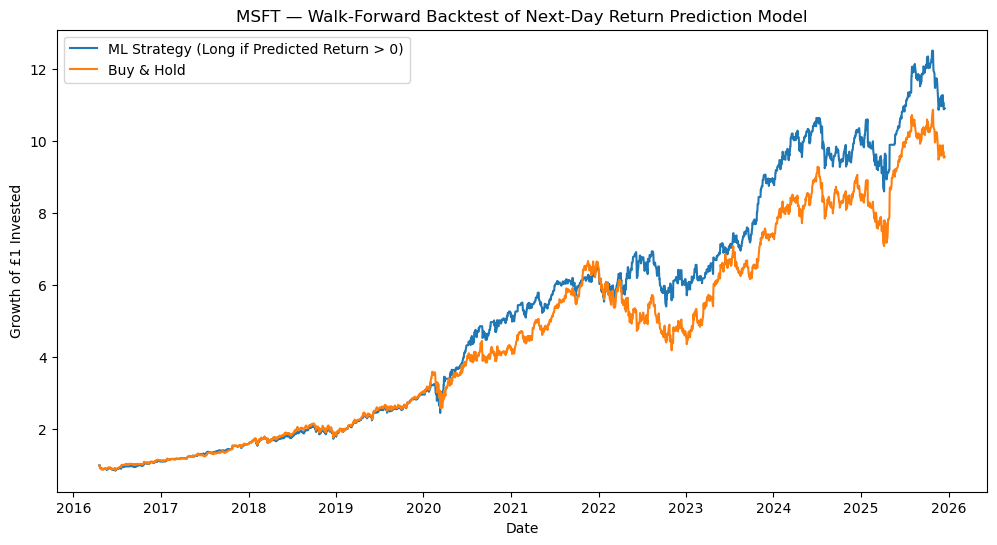

In [8]:
#I built a disciplined empirical framework to test whether short-horizon return predictability exists using engineered market features,
#validated via walk-forward testing, and evaluated through risk-adjusted backtesting rather than raw forecast accuracy




import numpy as np
import pandas as pd
import yfinance as yf

from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np



from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error


import matplotlib.pyplot as plt

pd.set_option("display.float_format", lambda x: f"{x:,.6f}")

#PART 2 

ticker = "MSFT"      # change me
start = "2015-01-01"
end   = None         # or "2025-01-01"

df = yf.download(ticker, start=start, end=end, auto_adjust=True, progress=False)    #auto adjust is true part accounts for dividends/splits 
df = df.dropna()
df.head()

#Part 3 Turn prices into meaningful numerical signals the model can learn from.
# We do not predict price. We predict next-day return, which is: more stable, statistically sound, how professionals model markets

data = df.copy()

# Past returns (momentum)
data["ret_1"] = data["Close"].pct_change(1)
data["ret_5"] = data["Close"].pct_change(5)
data["ret_10"] = data["Close"].pct_change(10)

# Volatility (risk proxy)
data["vol_10"] = data["ret_1"].rolling(10).std()

#Volatility often: reduces predictability, changes signal effectiveness . Including it allows the model to condition predictions on risk environment, not treat all periods equally.

# Trend indicator
data["ma_gap"] = (
    data["Close"].rolling(10).mean() /
    data["Close"].rolling(20).mean() - 1
)
#Moving average gap: trend & sentiment ^^

# Volume activity - Theory: Volume proxies information flowPrice changes with volume are more informative
#Low-volume moves are more likely noise. This ties back to market microstructure theory.

data["volchg_5"] = data["Volume"].pct_change(5)


# Target: tomorrow’s return
data["y"] = data["Close"].pct_change(1).shift(-1)

data = data.dropna()


#WE HAVE INCOOPERATED MOMENTUM, RISK, TREND AND INFORMATION TO CONSTRUCT OUR ANALYSIS AND SIGNALS

# ----------------------------------------------------------------------------------------------------------#




#Task 4 - Separate inputs (X) and target (y)Goal: Prepare data for machine learning.   X = information available today , y = outcome tomorrow  - No future leakage

features = ["ret_1","ret_5","ret_10","vol_10","ma_gap","volchg_5"]
X = data[features]
y = data["y"]

#Task 5: Define models to compare - Goal: Show progression from simple → advanced ML.  Why this is impressive: Baseline proves you’re not fooling yourself 
# Ridge = interpretable linear ML Random Forest = non-linear ML


models = {
    "Baseline": None,  # predicts zero return
    "Ridge": Pipeline([
        ("scaler", StandardScaler()),
        ("model", Ridge(alpha=1.0))
    ]),
    "RandomForest": RandomForestRegressor(
        n_estimators=300,
        max_depth=6,
        random_state=42
    )
}
    #HERE WE HAVE USED A BASELINE MODEL, RIDGE MODEL AND RANDOM FOREST MODEL

#Task 6 : Walk-forward validation - Goal: Test models exactly how they would run in real life.
# Key concept: Train on the past → predict the future  , Repeat moving forward - This avoids look-ahead bias, a common beginner mistake

tscv = TimeSeriesSplit(n_splits=8)
preds = pd.Series(index=X.index, dtype=float)

model_name = "Ridge"
model = models[model_name]

for train_idx, test_idx in tscv.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train = y.iloc[train_idx]

    if model_name == "Baseline":
        fold_pred = np.zeros(len(X_test))
    else:
        model.fit(X_train, y_train)
        fold_pred = model.predict(X_test)

    preds.iloc[test_idx] = fold_pred


# Random test sampling/ splitting won't work because a random split mixes past and future data - CALLED 'LOOK AHEAD BIAS' 
# Therefore we must use Walk-Forward validation - Walk-forward validation enforces a causal structure: At time t, you are only allowed to use information available at or before t
 # ------------------------------------------------------------------------------------------#

#Task 7 : Seeing if the predictions are useful and not just accurate - If the model predicts positive returns → go long,  Otherwise → stay in cash , This converts ML output into a decision rule

oos = data.loc[preds.dropna().index].copy()
oos["pred"] = preds.dropna()
oos["actual"] = oos["y"]

# Accuracy metrics
mae = mean_absolute_error(oos["actual"], oos["pred"])
mse = mean_squared_error(oos["actual"], oos["pred"])
rmse = np.sqrt(mse)

# Simple trading rule
oos["signal"] = (oos["pred"] > 0).astype(int)
oos["strategy_ret"] = oos["signal"] * oos["actual"]

#Predictions are useless without a decision rule.

#Your rule:
#Go long if 𝑟^𝑡+1>0

#backtesting using sharpe ratio, strategy returns and equity curve

#Task 8: Visualise performance
# What this shows: - Whether the model adds value vs holding the stock - Exactly what interviewers want to see

oos["equity_strategy"] = (1 + oos["strategy_ret"]).cumprod()
oos["equity_buyhold"] = (1 + oos["actual"]).cumprod()

plt.figure(figsize=(12,6))
plt.plot(oos.index, oos["equity_strategy"], label="ML Strategy (Long if Predicted Return > 0)")
plt.plot(oos.index, oos["equity_buyhold"], label="Buy & Hold")

plt.title(f"{ticker} — Walk-Forward Backtest of Next-Day Return Prediction Model")
plt.xlabel("Date")
plt.ylabel("Growth of £1 Invested")
plt.legend()
plt.show()

#Task 9 : Compare models - Goal: Rank models objectively. This step proves: You think like a researcher, not a demo coder 

results = []
for name in models:
    # run walk-forward again per model
    # collect MAE, RMSE, Sharpe
    pass











